In [1]:
import sys
sys.path.append('../')
import env

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from collections import namedtuple

In [3]:
one_length = env.AREA_ONE_LENGTH()

In [4]:
def area_to_contour(area_id):
    area_id = int(area_id)
    left = str(area_id // one_length)
    right = str(area_id % one_length) + '0'
    return left+right


def contour_to_area(contour_id):
    contour_id = str(contour_id)
    left = int(contour_id[0]) * one_length
    right = int(contour_id[1])
    
    return left+right

In [5]:
csv_array = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('2D', args),
                                                        encoding='Shift_JISx0213')
    df['time'] = df['time'].apply(lambda x: str(int(x)))
    df['area'] = df['area'].apply(lambda x: area_to_contour(x))
    df['people'] = df['people'].apply(lambda x: int(x))

    group_list = df.groupby(['time'], sort=False)
    for _times, _group in group_list:
        array[args.dir][args.ratio][args.seed][args.csv][_times] = _group
        
env.for_default_init(main, csv_array, ['mobile', 'census', 'census1', 'census2'])

In [6]:
people = 'p10000'
ratio = 'r4'
seed = 's123'

In [7]:
csv_array['p10000']['r4']['s123']['census1']['3600'].head()

,time,area,people
0,3600,000,0
1,3600,010,13
2,3600,020,0
3,3600,030,0
4,3600,040,0


In [8]:
contour_list = [area_to_contour(i) for i in range(one_length**2)]

In [9]:
class Coordinate:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __add__(a,b):
        return Coordinate(a.x+b.x, a.y+b.y)
    
    def distance(self):
        return round(np.sqrt(self.x**2 + self.y**2), 3)

In [10]:
def get_around_contour(contour_id):    
    array = {}
    
    y = int(contour_id[0])
    x = int(contour_id[1])
    
    array[1,0] = east = str(y) + str(x+1) + '0'
    array[1,1] = north_east = str(y+1) + str(x+1) + '0'
    array[0,1] = north = str(y+1) + str(x) + '0'
    array[-1,1] = north_west = str(y+1) + str(x-1) + '0'
    array[-1,0] = west = str(y) + str(x-1) + '0'
    array[-1,-1] = south_west = str(y-1) + str(x-1) + '0'
    array[0,-1] = south = str(y-1) + str(x) + '0'
    array[1,-1] = south_east = str(y-1) + str(x+1) + '0'
    
    for _index, _item in array.items():
        if (len(_item) > 3) or (_item.find(str(one_length)) != -1):
            array[_index] = -1
    
    return array

In [11]:
coordinate_array = {}
for _area in env.AREA_LIST_CONTOUR():
    coordinate_array[_area] = None
coordinate_array[-1] = -1

def set_coordinate_3d(contour_id, center=Coordinate(0,0)):    
    coordinate_array[contour_id] = center 

    for _xy, _area in get_around_contour(contour_id).items():
        if coordinate_array[_area] == None:
            coordinate = Coordinate(_xy[0], _xy[1])
            coordinate_array[_area] = center + coordinate
            set_coordinate_3d(_area, center+coordinate)

In [12]:
set_coordinate_3d('540')
coordinate_array.pop(-1)

-1

In [13]:
def create_network(args, array):
    for _times in env.TIMES_LIST():
        df = csv_array[args.dir][args.ratio][args.seed][args.csv][_times].copy()

        network = nx.DiGraph()
        for _area in contour_list:
            network.add_node(_area)

            coordinate = get_around_contour(_area)
            for _around_area in coordinate.values():
                if _around_area != -1:
                    network.add_edge(_area, _around_area, 
                                     people=df.loc[df['area'] == _around_area, 'people'].values[0], 
                                     distance=coordinate_array[_around_area].distance()
                    )
                
        array[args.dir][args.ratio][args.seed][args.csv][_times] = network
    return array

network_array = {}
env.for_default_init(create_network, network_array, ['census1', 'census2'])

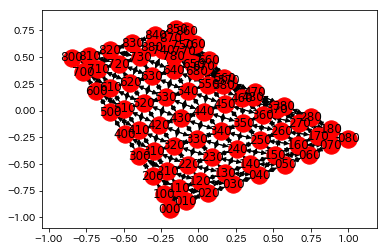

AtlasView({'550': {'people': 17, 'distance': 1.0}, '650': {'people': 19, 'distance': 1.414}, '640': {'people': 14, 'distance': 1.0}, '630': {'people': 6, 'distance': 1.414}, '530': {'people': 19, 'distance': 1.0}, '430': {'people': 0, 'distance': 1.414}, '440': {'people': 20, 'distance': 1.0}, '450': {'people': 16, 'distance': 1.414}})

In [14]:
n = network_array[people][ratio][seed]['census1']['3600'].copy()
nx.draw_networkx(n)
plt.show()
n['540']

In [15]:
import random

def create_start(args, array):
    print(args.dir, args.ratio, args.seed)
    
    for _times in env.TIMES_LIST():
        start_array[args.dir][args.ratio][args.seed][_times] = {}
        
        df = csv_array[args.dir][args.ratio][args.seed]['mobile'][_times].copy()
        df['people'] = df['people']
        df = df[df['people'] != 0]

        stack_area = list(df['area'].values)
        stack_people = df['people'].sum()
        print(_times, ', start_stack: ', stack_people)

        for vehicle_id in range(stack_people): 
            random_area = random.choice(stack_area)
            df_choiced = df.loc[df['area'] == random_area, :]
            start_array[args.dir][args.ratio][args.seed][_times][vehicle_id] = df_choiced['area'].values[0]
            df.loc[df_choiced.index[0], 'people'] -= 1

            if df.loc[df_choiced.index[0], 'people'] == 0:
                stack_area.remove(random_area)
                df = df.drop(df_choiced.index[0])
    print('\n')
    
start_array = {}
env.for_exclude_csv_init(create_start, start_array)

p10000 r4 s123
3600 , start_stack:  305
7200 , start_stack:  655
10800 , start_stack:  698
14400 , start_stack:  667
18000 , start_stack:  501
21600 , start_stack:  267




In [16]:
import math

# 7200から開始した時、3600mobileの人数+(7200mobileの人数-3600mobileの人数)をcensus1とcensus2の割合ごとに人数を分ける
# 0~3600, 3600~7200の後者を指定する
def calcurlate_stack(args, array):
    times_list = env.TIMES_LIST()
    for _times in times_list:
        time_index = times_list.index(_times)

        mobile_end = csv_array[people][ratio][seed]['mobile'][_times]['people'].copy()
        mobile_start = pd.Series()
        if time_index != 0:
            mobile_start = csv_array[people][ratio][seed]['mobile'][times_list[time_index-1]]['people'].copy()

        census1 = csv_array[args.dir][args.ratio][args.seed]['census1'][_times]['people'].copy()
        census2 = csv_array[args.dir][args.ratio][args.seed]['census2'][_times]['people'].copy()

        census_sum = census1.sum() + census2.sum()
        mobile_diff = mobile_end.sum() - mobile_start.sum()

        # previousの人数計算
        # 継続人数を計算
        continue1 = math.modf(census1.sum() / census_sum * mobile_start.sum())
        continue2 = math.modf(census2.sum() / census_sum * mobile_start.sum())
        decimal = round(continue1[0]+continue2[0])
        continue1 = int(continue1[1])
        continue2 = int(continue2[1])
        if continue1 > continue2:
            continue1 += decimal
        else:
            continue2 += decimal

        # 差分==新しく出現 の人数を計算
        new1 = math.modf(census1.sum() / census_sum * mobile_diff)
        new2 = math.modf(census2.sum() / census_sum * mobile_diff)
        decimal = round(new1[0]+new2[0])
        new1 = int(new1[1])
        new2 = int(new2[1])
        if new1 > new2:
            new1 += decimal
        else:
            new2 += decimal

#         print(args.dir, args.ratio, args.seed, _times)
#         print('合計 : ', mobile_start.sum(), ' : ',mobile_diff)
#         print('census1: ', continue1, ', ', new1)
#         print('census2: ', continue2, ', ', new2)
#         print('\n')

#         continue1+new1, continue2+new2
        array[args.dir][args.ratio][args.seed][_times] = continue1+new1

In [17]:
# people1, people2 = calcurlate_stack('3600')
stack_array = {}
env.for_exclude_csv_init(calcurlate_stack, stack_array)

In [18]:
vehicle_route_array = {}
start_census_array = {}

for_list = env.get_for_list()
for _dir in for_list.dir:
    vehicle_route_array[_dir] = {}
    start_census_array[_dir] = {}

    for _ratio in for_list.ratio:
        vehicle_route_array[_dir][_ratio] = {}
        start_census_array[_dir][_ratio] = {}

        for _seed in for_list.seed:
            vehicle_route_array[_dir][_ratio][_seed] = {}
            start_census_array[_dir][_ratio][_seed] = {}

            for _times in env.TIMES_LIST():
                vehicle_route_array[_dir][_ratio][_seed][_times] = {}

                # 経由ルートをスタックするので初期化
                for _id, _start_area in start_array[_dir][_ratio][_seed][_times].items():
                    vehicle_route_array[_dir][_ratio][_seed][_times][_id] = []
#                     vehicle_route_array[_dir][_ratio][_seed][_times][_id].append(_start_area)
                    #  初期位置を確保するために事前に-1
                    mobile = csv_array[_dir][_ratio][_seed]['mobile'][_times]
                    mobile.loc[mobile['area'] == _start_area, 'people'] -= 1


                start_census_items = start_array[_dir][_ratio][_seed][_times].items()
                start_census_array['census1'] = dict(list(start_census_items)[:stack_array[_dir][_ratio][_seed][_times]])
                start_census_array['census2'] = dict(list(start_census_items)[stack_array[_dir][_ratio][_seed][_times]:])

In [19]:
def estimate_vehicle_route(args):
    for _times in env.TIMES_LIST():
        network = network_array[args.dir][args.ratio][args.seed][args.csv][_times].copy()

        for _id, _start_area in start_census_array[args.csv].items():
            if _id in vehicle_route_array[args.dir][args.ratio][args.seed][_times]:
                next_area = _start_area

                route_length = random.randrange(5, 15)
#                 print('長さ: ', route_length)
#                 print('_srat_area: ', _start_area)
                for _ in range(route_length):
#                     print('回数: ', _)
#                     print('next_area: ', next_area)
                    now_node = network[next_area]
                    now_node = dict(sorted(now_node.items(), key=lambda x: x[1]['distance'], reverse=(False if args.csv == 'census1' else True)))
                    node_list = list(now_node.keys())

                    for _index, _around_area in enumerate(node_list):
                        # 同じエリアには通らないようにする
                        if _around_area in vehicle_route_array[args.dir][args.ratio][args.seed][_times][_id]:
                            continue
                            
                        # 通ったエリアの人数を-1
                        census = csv_array[args.dir][args.ratio][args.seed][args.csv][_times]
                        if census.loc[census['area'] == next_area, 'people'].values[0] <= 0:
                            continue
                        census.loc[census['area'] == next_area, 'people'] -= 1

                        # 配列にルートを追加
#                         print('node_list: ', node_list)
#                         print(vehicle_route_array[args.dir][args.ratio][args.seed][_times][_id])
                        vehicle_route_array[args.dir][args.ratio][args.seed][_times][_id].append(next_area)
#                         print(vehicle_route_array[args.dir][args.ratio][args.seed][_times][_id])
                        
                        # 次のエリアを設定
                        next_area = node_list[_index]
                        next_node = network[next_area]
                        # 次のエリアが一つ決まれば良いのでbreak
                        break
                        
                    # censusが0なら通るルートがなくなったので終了
                    if (csv_array[args.dir][args.ratio][args.seed][args.csv][_times]['people'].sum() <= 0):
                        break

env.for_default(estimate_vehicle_route, ['census1', 'census2'])

In [20]:
def count_sum_route(args):
    for _times in env.TIMES_LIST():
        route_array = vehicle_route_array[args.dir][args.ratio][args.seed][_times].copy()
        print(args.dir, args.ratio, args.seed, _times)

        counter = 0
        for _routes in route_array.values():
            counter += len(_routes)
        print('route: ', counter)

        counter += csv_array[args.dir][args.ratio][args.seed]['census'][_times]['people'].sum()
        print('census:', counter, '\n')
        
env.for_exclude_csv(count_sum_route)

p10000 r4 s123 3600
route:  429
census: 1912 

p10000 r4 s123 7200
route:  642
census: 4116 

p10000 r4 s123 10800
route:  596
census: 4233 

p10000 r4 s123 14400
route:  588
census: 4005 

p10000 r4 s123 18000
route:  503
census: 2913 

p10000 r4 s123 21600
route:  436
census: 2115 



In [21]:
def set_to_df(args, array):
    for _times in env.TIMES_LIST():
        df = pd.DataFrame(columns=['id', 'type','csv'])
        vehicle_route = vehicle_route_array[args.dir][args.ratio][args.seed][_times].copy()
        df = pd.DataFrame(list(vehicle_route.keys()), columns=['id'])
        df['type'] = 'Vehicle'
        stack = stack_array[args.dir][args.ratio][args.seed][_times]
        df['csv'] = df['id'].apply(lambda x: 'census1' if x < stack else 'census2')
        df = pd.concat([df, pd.DataFrame(list(vehicle_route.values()))], axis=1)
        array[args.dir][args.ratio][args.seed][_times] = df.copy()
        df.to_csv(env.get_full_path('estimate', args, any=_times), index=False, header=False)
    
estimate_od_array = {}
env.for_default_init(set_to_df, estimate_od_array, ['estimate'])

In [22]:
estimate_od_array[people][ratio][seed]['3600'].iloc[:, 3:]

,0,1,2,3,4,5,6,7,8,9,10
0,None,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,None
2,420,530,540,550,640,650,None,None,None,None,None
3,520,530,540,550,640,650,None,None,None,None,None
4,320,None,None,None,None,None,None,None,None,None,None
5,230,340,440,540,550,640,530,630,None,None,None
6,760,650,540,550,640,530,440,450,560,660,750
7,530,540,550,640,650,None,None,None,None,None,None
8,750,640,540,550,440,530,630,None,None,None,None
9,840,None,None,None,None,None,None,None,None,None,None


In [23]:
od_array = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('Origin', args),
                     names=env.get_col_names(),
                     encoding='Shift_JISx0213')
    array[args.dir][args.ratio][args.seed][args.csv] = df.copy()
        
env.for_default_init(main, od_array, ['od'])

In [24]:
od_array[people][ratio][seed]['od'].head()

,c00,c01,c02,c03,c04,c05,c06,c07,c08,c09,...,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29
0,15131,Vehicle,FALSE,国道8号p(census)@389,国道8号o(census)@419,国道8号n(census)@503,石川県道198号a(census)@884,石川県道198号b(census)@887,,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12929,Vehicle,FALSE,石川県道17号b(census)@430,石川県道8号l(census)@439,石川県道8号k(census)@543,石川県道8号j(census)@587,石川県道8号i(census)@722,石川県道291号b(census)@959,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15542,Vehicle,FALSE,石川県道196号k(census)@908,石川県道196号e(census)@1099,,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,19899,Vehicle,FALSE,石川県道8号s(census)@994,,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16531,Vehicle,FALSE,石川県道196号d(census)@753,国道8号h(census)@800,国道8号i(census)@858,国道8号j(census)@873,国道8号k(census)@952,国道8号l(census)@1008,国道8号m(census)@1043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
od_array[people][ratio][seed]['od'].shape

(2398, 30)

In [26]:
od_array2d = {}
def main(args, array):
    df = pd.read_csv(env.get_full_path('2D', args),
                     encoding='Shift_JISx0213')
    array[args.dir][args.ratio][args.seed][args.csv] = df.copy()
        
env.for_default_init(main, od_array2d, ['od'])

In [27]:
df = od_array2d[people][ratio][seed]['od']
df.loc[df['time'] == 3600.0, 'people'].sum()

1442.0

In [28]:
# def concat_estimate_od(args, array):
#     times_list = env.TIMES_LIST()
#     df_concate = estimate_od_array[args.dir][args.ratio][args.seed][times_list[0]].iloc[:, 3:].copy()
    
#     for _times in times_list[1:]:
#         df = estimate_od_array[args.dir][args.ratio][args.seed][_times].iloc[:, 3:].copy()
#         df_concate = pd.concat([df_concate, df])
        
#     df_concate.to_csv(env.get_full_path('estimate', args, any='estimate'), index=False)
#     array[args.dir][args.ratio][args.seed] = df_concate.copy()
    

# estimate_od_sum_array = {}
# env.for_exclude_csv_init(concat_estimate_od, estimate_od_sum_array)

In [29]:
def create_next_move_area(df, area):
    area = float(area)
    df_area = pd.DataFrame(np.zeros((81, 2)), columns=['area', 'people'])
    df_area['area'] = [float(i) for i in range(81)]

    for row in df.values.tolist():
        if area in row:
            index = row.index(area)
            if (len(row) > index + 1) and (not np.isnan(row[index + 1])):
                df_area.loc[df_area['area'] == row[index + 1], 'people'] += 1

    return df_area

In [30]:
# def next_move_area(args):
#     df = pd.read_csv(env.get_full_path('estimate', args, any='estimate'))
#     for _area in env.get_area_list():
#         df_area = create_next_move_area(df.copy(), _area)
#         df_area.to_csv(env.get_full_path('next_move_area', args, any='estimate'+str(_area)), index=False)
        
# env.for_exclude_csv(next_move_area)